In [10]:
import torch
import clip
from openai_imagenet_template import openai_imagenet_template

classnames = [
    "porcupine",
    "echidna",
    "mink",
    "beaver",
    "European polecat",
    "truck"
]
device = "cuda"

model, _ = clip.load("ViT-B/32", device=device)
embs = []
with torch.no_grad():
    for classname in classnames:
        texts = [t(classname) for t in openai_imagenet_template]
        tokenized = clip.tokenize(texts).to(device)
        emb = model.encode_text(tokenized)
        emb = emb / emb.norm(dim=-1, keepdim=True)
        embs.append(emb)

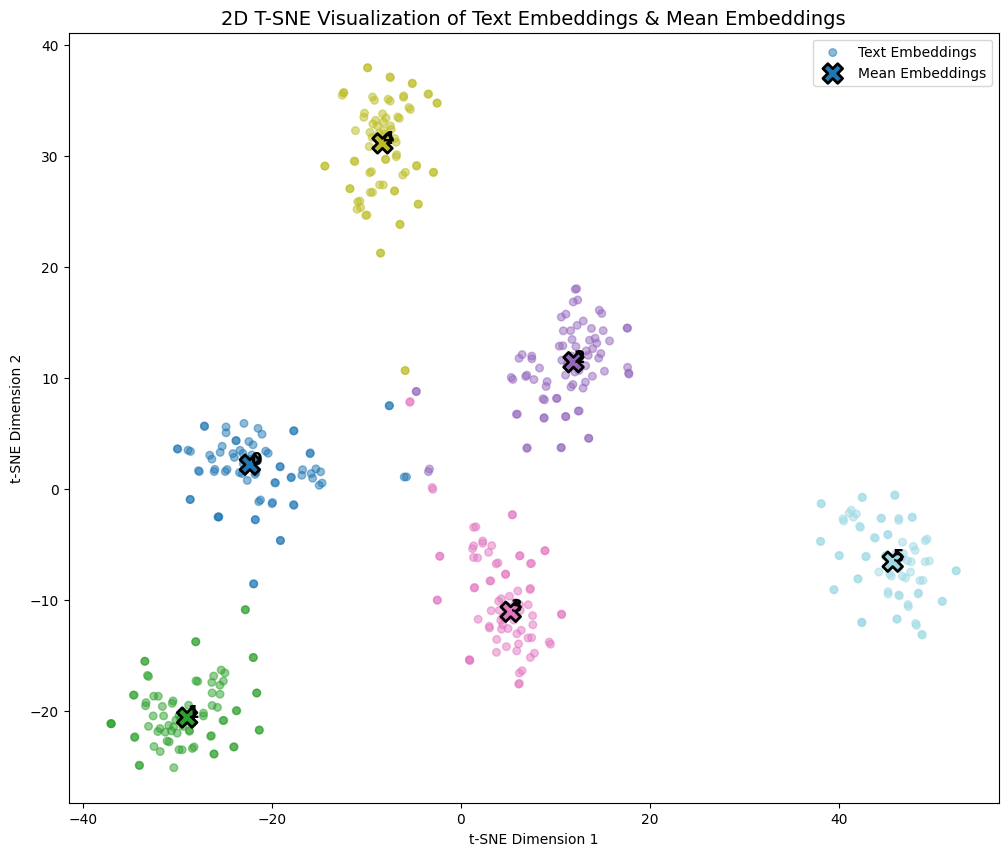

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize


# 데이터 로드
# image_embeddings = np.load("tsne/unified/no_icv_image_embeddings_11_icv.npy") # (N, D)
# image_labels = np.load("tsne/unified/no_icv_image_labels_icv.npy")  # (N,)

# 파일 불러오기
embedding_0 = embs[0].to("cpu").numpy()
embedding_1 = embs[1].to("cpu").numpy()
embedding_2 = embs[2].to("cpu").numpy()
embedding_3 = embs[3].to("cpu").numpy()
embedding_4 = embs[4].to("cpu").numpy()
embedding_5 = embs[5].to("cpu").numpy()

# 전체 데이터 합치기
image_embeddings = np.vstack([embedding_0, embedding_1, embedding_2, embedding_3, embedding_4, embedding_5])

# 라벨 생성 (각 이미지의 개수만큼 반복)
labels_0 = np.full(len(embedding_0), 0)  # 0번 라벨
labels_1 = np.full(len(embedding_1), 1)  # 1번 라벨
labels_2 = np.full(len(embedding_2), 2)  # 2번 라벨
labels_3 = np.full(len(embedding_3), 3)  # 1번 라벨
labels_4 = np.full(len(embedding_4), 4)  # 2번 라벨
labels_5 = np.full(len(embedding_5), 5)  # 2번 라벨
image_labels = np.concatenate([labels_0, labels_1, labels_2, labels_3, labels_4, labels_5])

# 각 label별 평균 embedding 계산
unique_labels = np.unique(image_labels)  # 고유한 라벨 찾기
mean_embeddings = np.array([image_embeddings[image_labels == label].mean(axis=0) for label in unique_labels])

# image_embeddings와 mean_embeddings을 함께 T-SNE 적용 (2D)
# combined_embeddings = np.vstack([image_embeddings])  # (N + num_classes, D)
combined_embeddings = np.vstack([image_embeddings, mean_embeddings]) 
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(combined_embeddings)

# 분리: image_embeddings과 mean_embeddings의 변환 결과
embeddings_2d_images = embeddings_2d[:len(image_embeddings)]  # 원본 이미지 임베딩
embeddings_2d_means = embeddings_2d[len(image_embeddings):]  # 평균 임베딩

# 컬러맵 정의 (100가지 컬러 사용 가능)
cmap = plt.get_cmap("tab20", len(unique_labels))

# 2D 시각화
plt.figure(figsize=(12, 10))

# 원래 image_embeddings 시각화
plt.scatter(
    embeddings_2d_images[:, 0], embeddings_2d_images[:, 1],
    c=image_labels, cmap=cmap, alpha=0.5, s=30, label="Text Embeddings"
)

# mean_embeddings 시각화 (크기 증가 + 테두리 강조)
plt.scatter(
    embeddings_2d_means[:, 0], embeddings_2d_means[:, 1],
    c=unique_labels, cmap=cmap, marker="X", s=200, edgecolors="black", linewidths=2, alpha=1.0, label="Mean Embeddings"
)

# Mean Embeddings에 라벨 추가
for i, label in enumerate(unique_labels):
    plt.text(
        embeddings_2d_means[i, 0], embeddings_2d_means[i, 1], str(label),
        color="black", fontsize=12, fontweight="bold"
    )

plt.title("2D T-SNE Visualization of Text Embeddings & Mean Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

In [13]:
def get_null_text_embedding(clip_model, template, device):
    """
    클래스 정보를 제거한 'null text embedding'을 계산한다.
    예: "a photo of <|endoftext|>", "a photo of something", "a photo of object" 등

    Args:
        clip_model: CLIP 모델 (encode_text 메서드를 가져야 함)
        template: 클래스 이름을 포함하는 text template 함수 리스트
        device: torch device

    Returns:
        null_text_emb: (D,) 크기의 평균 정규화된 텍스트 임베딩 (float32)
    """
    null_classnames = ["<|endoftext|>", "something", "object"]
    null_embs = []

    with torch.no_grad():
        for null_cls in null_classnames:
            texts = [t(null_cls) for t in template]  # 예: "a photo of object"
            tokenized = clip.tokenize(texts).to(device)
            emb = clip_model.encode_text(tokenized)  # (T, D)
            emb = emb / emb.norm(dim=-1, keepdim=True)  # 정규화
            mean_emb = emb.mean(dim=0)
            mean_emb = mean_emb / mean_emb.norm()  # 다시 정규화
            null_embs.append(mean_emb)

    null_text_emb = torch.stack(null_embs, dim=0).mean(dim=0)
    null_text_emb = null_text_emb / null_text_emb.norm()  # 최종 정규화

    return null_text_emb.float()

null_text_emb = get_null_text_embedding(model, openai_imagenet_template, device)

null_text_emb.shape

torch.Size([512])